<a href="https://colab.research.google.com/github/vanessaaleung/ds-case-studies/blob/master/modeling/taxi-fare/predict_taxi_fares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
library(tidyverse)

taxi <- read_csv('datasets/taxi.csv')
head(taxi)

Parsed with column specification:
cols(
  medallion = col_character(),
  pickup_datetime = col_datetime(format = ""),
  pickup_longitude = col_double(),
  pickup_latitude = col_double(),
  trip_time_in_secs = col_double(),
  fare_amount = col_double(),
  tip_amount = col_double()
)


medallion,pickup_datetime,pickup_longitude,pickup_latitude,trip_time_in_secs,fare_amount,tip_amount
4D24F4D8EF35878595044A52B098DFD2,2013-01-13 10:23:00,-73.94646,40.77273,600,8.0,2.5
A49C37EB966E7B05E69523D1CB7BE303,2013-01-13 04:52:00,-73.99827,40.74041,840,18.0,0.0
1E4B72A8E623888F53A9693C364AC05A,2013-01-13 10:47:00,-73.95346,40.77586,60,3.5,0.7
F7E4E9439C46B8AD5B16AB9F1B3279D7,2013-01-13 11:14:00,-73.98137,40.72473,720,11.5,2.3
A9DC75D59E0EA27E1ED328E8BE8CD828,2013-01-13 11:24:00,-73.96800,40.76000,240,6.5,0.0
19BF1BB516C4E992EA3FBAEDA73D6262,2013-01-13 10:51:00,-73.98502,40.76341,540,8.5,1.7


## 1. Cleaning the taxi data

In [ ]:
taxi <- taxi %>%
   rename(lat='pickup_latitude', long='pickup_longitude') %>%
    filter(fare_amount > 0 | tip_amount > 0) %>%
    mutate(total=log(fare_amount + tip_amount))

In [ ]:
# Zooming in on Manhattan
taxi <- taxi  %>% 
    filter(lat >= 40.70 & lat <= 40.83 & long >= -74.025 & long <= -73.93)

## 2. Where does the journey begin?
The map from the previous task showed that the journeys are highly concentrated in the business and tourist areas. We also see that some taxi trips originating in Brooklyn slipped through, but that's fine.

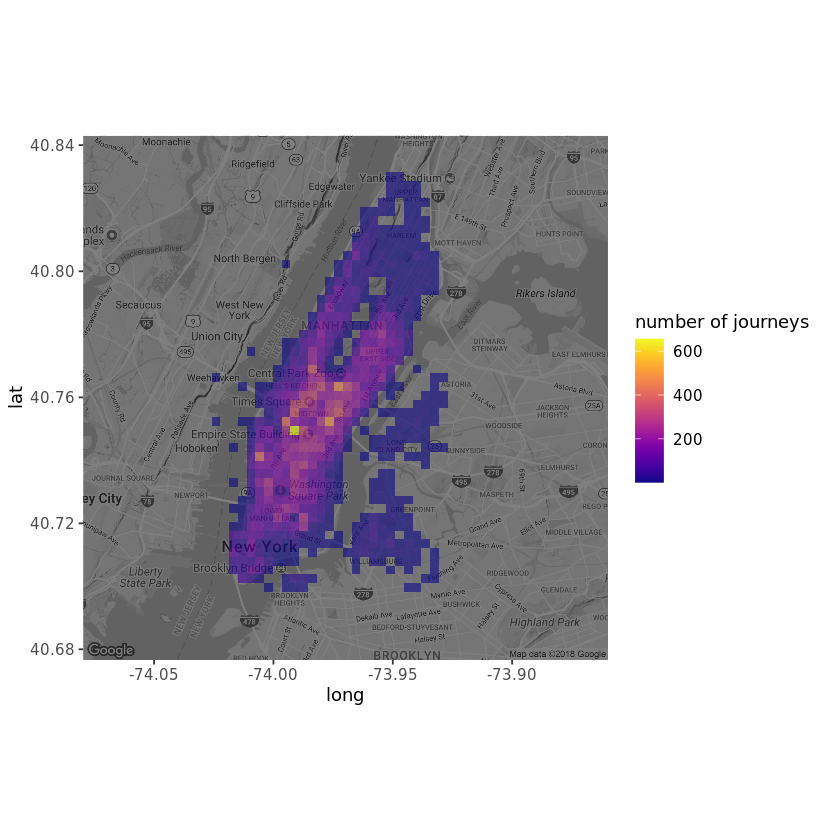

In [ ]:
library(ggmap)
library(viridis)

manhattan <- readRDS("datasets/manhattan.rds")

ggmap(manhattan, darken = 0.5) +
   scale_fill_viridis(option = 'plasma') +
   geom_bin2d(data=taxi, aes(x=taxi$long, y=taxi$lat), bins=60, alpha=0.6) + 
    labs(x='long', y='lat', fill='number of journeys')

## 3. Predicting taxi fares using a tree
The tree below looks a bit frugal, it only includes one split: It predicts that trips where lat < 40.7237 are more expensive, which makes sense as it is downtown Manhattan. But that's it. It didn't even include long as tree deemed that it didn't improve the predictions.

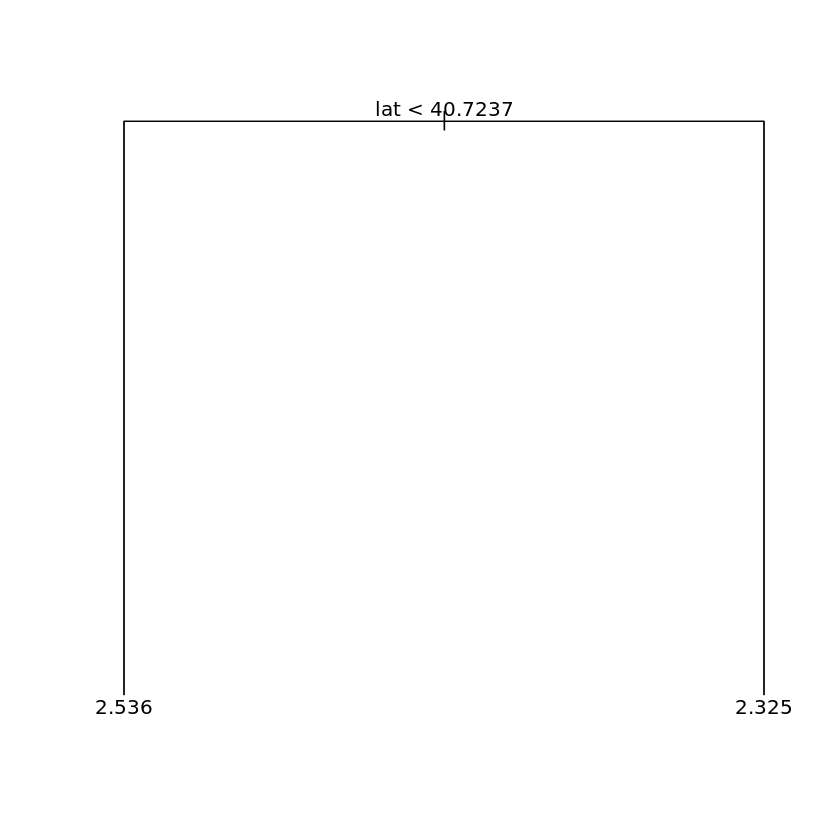

In [ ]:
library(tree)

fitted_tree <- tree(total ~ lat + long, taxi)

plot(fitted_tree)
text(fitted_tree)

Try fitting a new regression tree where we include the new time variables.

In [ ]:
library(lubridate)

taxi <- taxi %>% 
    mutate(hour=hour(pickup_datetime), 
        wday=wday(pickup_datetime, label = TRUE), 
           month=month(pickup_datetime, label = TRUE))

The regression tree has not changed after including the three time variables. This is likely because latitude is still the most promising first variable to split the data on, and after that split, the other variables are not informative enough to be included. 


Regression tree:
tree(formula = total ~ lat + long + hour + wday + month, data = taxi)
Variables actually used in tree construction:
[1] "lat"
Number of terminal nodes:  2 
Residual mean deviance:  0.3041 = 13910 / 45760 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.61900 -0.37880 -0.04244  0.00000  0.32660  2.69900 

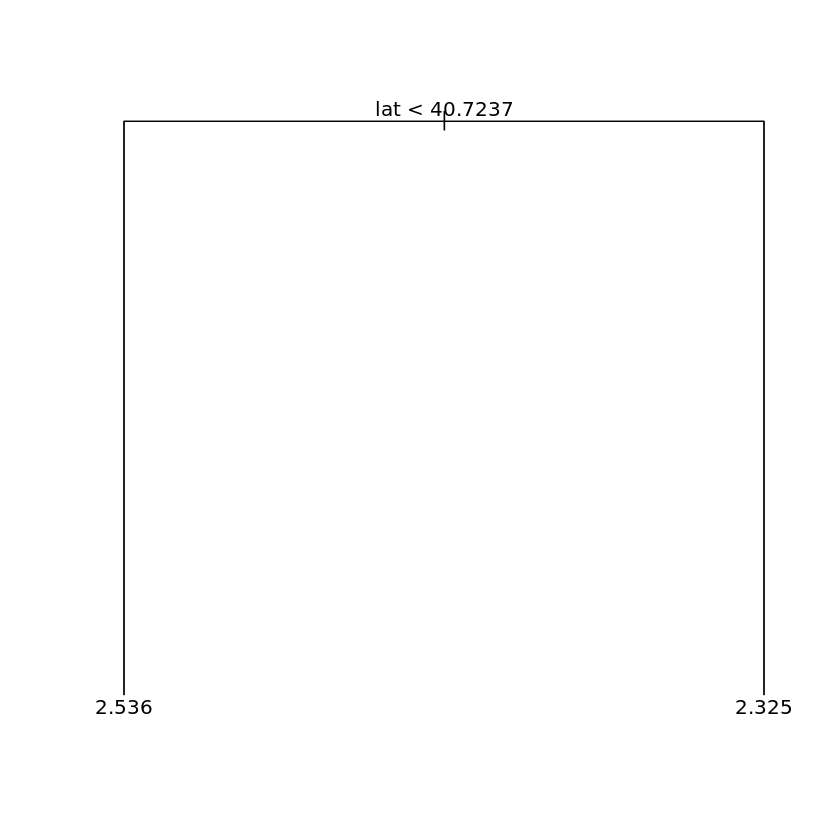

In [ ]:
fitted_tree <- tree(total ~ lat + long + hour + wday + month, taxi)

plot(fitted_tree)
text(fitted_tree)

summary(fitted_tree)

## 4. Fitting a Random Forest Model
<p>A random forest model, where many different trees are fitted to subsets of the data, may well include the other variables in some of the trees that make it up. </p>

In the output of fitted_forest we should see the Mean of squared residuals, that is, the average of the squared errors the model makes. If you scroll up and check the summary of fitted_tree you'll find Residual mean deviance which is the same number. If you compare these numbers, you'll see that fitted_forest has a slightly lower error. Neither predictive model is that good, in statistical terms, they explain only about 3% of the variance.

In [ ]:
library(randomForest)

fitted_forest <- randomForest(total ~ lat + long + hour + wday + month, taxi,
                            ntree=80, sampsize=10000)

print(fitted_forest)


Call:
 randomForest(formula = total ~ lat + long + hour + wday + month,      data = taxi, ntree = 80, sampsize = 10000) 
               Type of random forest: regression
                     Number of trees: 80
No. of variables tried at each split: 1

          Mean of squared residuals: 0.2997574
                    % Var explained: 2.78


<p>Looking at the map with the predicted fares we see that fares in downtown Manhattan are predicted to be high, while midtown is lower. This map only shows the prediction as a function of <code>lat</code> and <code>long</code>, but we could also plot the predictions over time, or a combination of time and space, but we'll leave that for another time.</p>

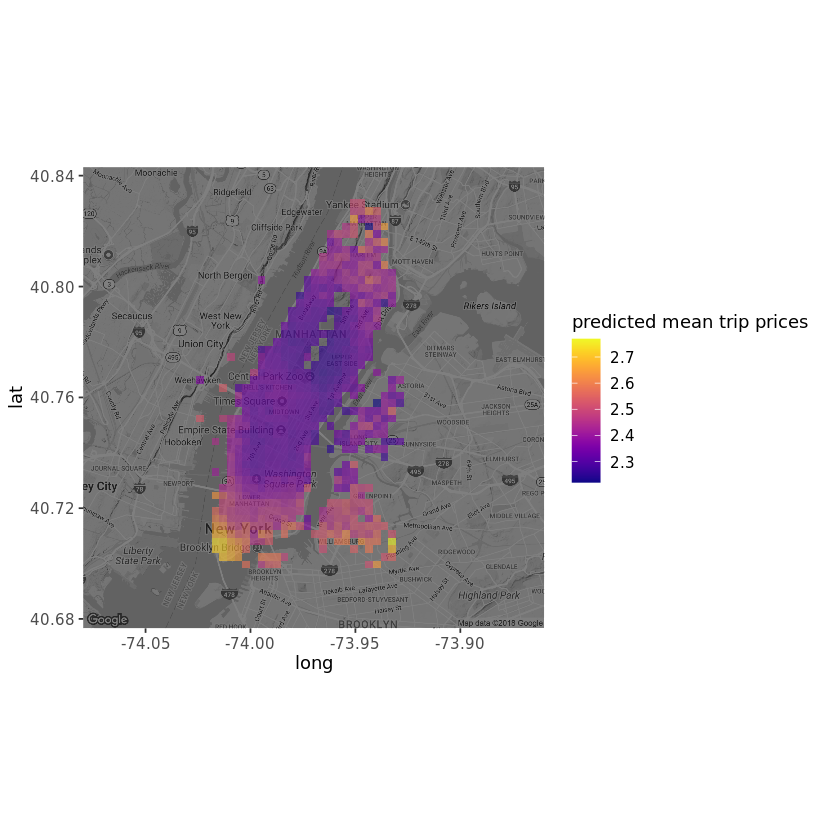

In [ ]:
taxi$pred_total <- fitted_forest$predicted

ggmap(manhattan, darken = 0.5) +
   scale_fill_viridis(option = 'plasma') +
   stat_summary_2d(data=taxi, aes(x=long, y=lat, z=pred_total), fun=mean, bins=60, alpha=0.6) + 
    labs(x='long', y='lat', fill='predicted mean trip prices')

## 5. Plotting the actual fare
<p>When comparing the map with the predicted fares with a new map showing the mean fares according to the data, it looks like the random forest model captured some of the patterns in our data.</p>



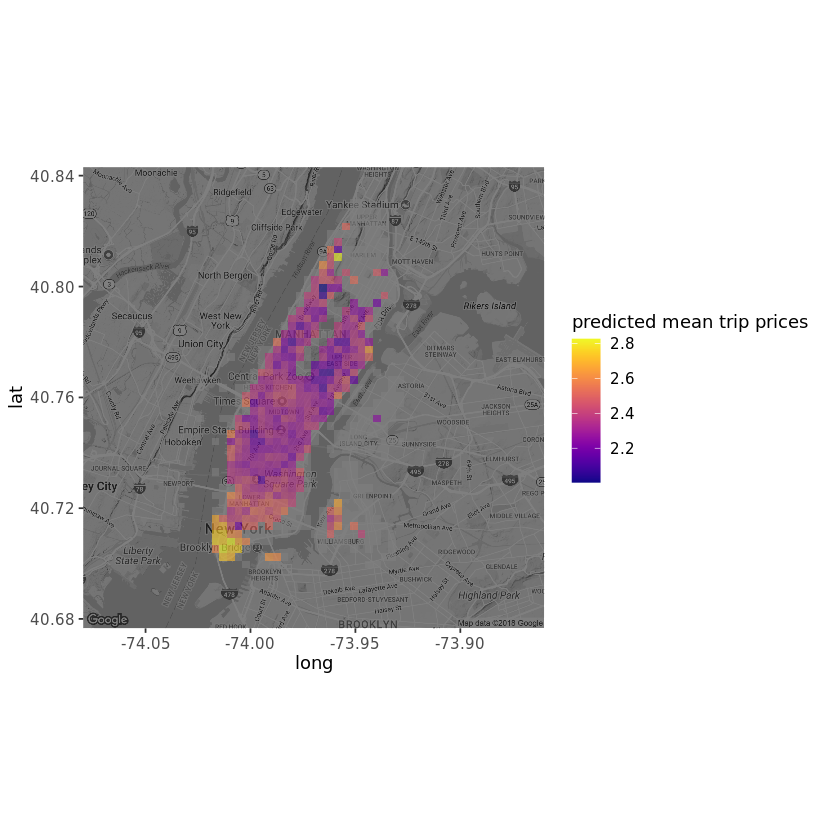

In [ ]:
mean_if_enough_data <- function(x) { 
    ifelse( length(x) >= 15, mean(x), NA) 
}

ggmap(manhattan, darken = 0.5) +
   scale_fill_viridis(option = 'plasma') +
   stat_summary_2d(data=taxi, aes(x=long, y=lat, z=total), fun=mean_if_enough_data, bins=60, alpha=0.6) + 
    labs(x='long', y='lat', fill='predicted mean trip prices')